In [88]:
import os
import json
import requests
from urllib.request import urlopen
import pandas as pd
import geopandas as gpd

# Load data

In [4]:
# get table names
path = '../data/EDA/'
files = os.listdir(path)
csv_files = [file for file in files if file.endswith('.csv')]
table_names = [file.split('.')[0] for file in csv_files]
table_names

# create dict of DataFrames for each table 
dfs = {}

for table_name in table_names:
    dfs[f'{table_name}'] = pd.read_csv(f'{path}{table_name}.csv')

## studentinfo: region map

I would like to create a map, showing where students are from. We will look at the regions, and try to find geoJSON data that fits.

In [104]:
df_studentinfo = dfs['studentinfo']
print(df_studentinfo['region'].unique())

['East Anglian Region' 'Scotland' 'North Western Region'
 'South East Region' 'West Midlands Region' 'Wales' 'North Region'
 'South Region' 'Ireland' 'South West Region' 'East Midlands Region'
 'Yorkshire Region' 'London Region']


I found geoJSON datasets, visualised on [https://martinjc.github.io/UK-GeoJSON/](https://martinjc.github.io/UK-GeoJSON/). They seem to be corresponding rather well.


['North East', 'North West', 'Yorkshire and The Humber', 'East Midlands', 'West Midlands', 'Eastern', 'London', 'South East', 'South West', 'Scotland', 'Wales']


<Axes: >

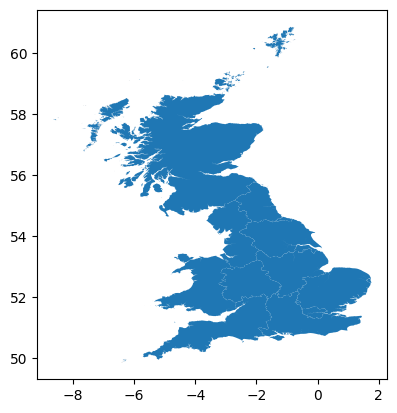

In [117]:
# get geoJSOn files
# GB
with urlopen('https://raw.githubusercontent.com/martinjc/UK-GeoJSON/refs/heads/master/json/electoral/gb/eer.json') as response:
    geojsonGB = json.load(response)
mapregion_namesGB = [region['properties']['EER13NM'] for region in geojsonGB['features']]
print(mapregion_namesGB)

gdfGB = gpd.GeoDataFrame.from_features(geojsonGB['features'])
gdfGB.plot()

In [110]:
# Let's look at JSON structure for dashboard
geojsonGB['features'][0]['properties']

{'EER13CD': 'E15000001', 'EER13CDO': '01', 'EER13NM': 'North East'}

We will be needing 'EER13NM' to identify the regions.

In [107]:
regions_mapping = {
    'East Anglian Region': 'Eastern',
    'Scotland': 'Scotland',
    'North Western Region': 'North West',
    'South East Region': 'South East',
    'West Midlands Region': 'West Midlands',
    'Wales': 'Wales',
    'North Region': None,
    'South Region': None,
    'Ireland': None,
    'South West Region': 'South West',
    'East Midlands Region': 'East Midlands',
    'Yorkshire Region': 'Yorkshire and The Humber',
    'London Region': 'London'
    }

We're missing 'North Region', 'South Region', and 'Ireland'. North Region and South Region seems a less granular division of England. Ireland is missing. We'll first look for Ireland.

['Outline of Northern Ireland']


<Axes: >

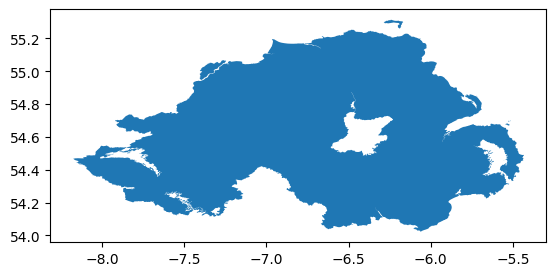

In [112]:
# Northern Ireland
with urlopen('https://raw.githubusercontent.com/martinjc/UK-GeoJSON/refs/heads/master/json/electoral/ni/eer.json') as response:
    geojsonNI = json.load(response)
mapregion_namesNI = [region['properties']['NAME'] for region in geojsonNI['features']]
print(mapregion_namesNI)
gdfNI = gpd.GeoDataFrame.from_features(geojsonNI['features'])
gdfNI.plot()

In [111]:
# Let's look at JSON structure for dashboard
geojsonNI['features'][0]['properties']

{'ID': 6834691,
 'NAME': 'Outline of Northern Ireland',
 'Area_SqKM': 13594.044105,
 'OBJECTID': 1}

Here we'll be needing 'NAME' to identify the region (instead of 'EER13NM'). Let's change the key in the geoJSON for Great Britain so they are all the same.

In [ ]:
for feature in geojsonGB['features']:
    feature['properties']['NAME'] = feature['properties'].pop('EER13NM')

# verify if key is changes correctly
mapregion_namesGB = [region['properties']['NAME'] for region in geojsonGB['features']]
print(mapregion_namesGB)

['North East', 'North West', 'Yorkshire and The Humber', 'East Midlands', 'West Midlands', 'Eastern', 'London', 'South East', 'South West', 'Scotland', 'Wales']


Let's combine both JSON files

c:\Users\user\.virtualenvs\learning_analytics-mXp6xlcY\lib\site-packages\pyogrio\geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


GeoJSON files successfully combined!


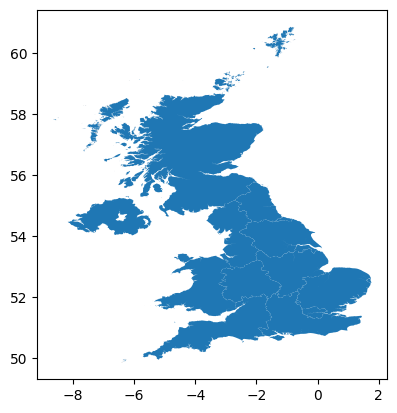

In [ ]:
gdfGB = gpd.GeoDataFrame.from_features(geojsonGB['features'])
gdfNI = gpd.GeoDataFrame.from_features(geojsonNI['features'])

# Combine the two GeoDataFrames
combined_gdf = gpd.GeoDataFrame(pd.concat([gdfGB, gdfNI], ignore_index=True))
combined_gdf.plot()

# Save the combined GeoDataFrame to a new GeoJSON file in data folder
combined_gdf.to_file('../data/combined_geojson.geojson', driver='GeoJSON')


In [123]:
# Let's verify if we have all regions
combined_gdf['NAME']

0                      North East
1                      North West
2        Yorkshire and The Humber
3                   East Midlands
4                   West Midlands
5                         Eastern
6                          London
7                      South East
8                      South West
9                        Scotland
10                          Wales
11    Outline of Northern Ireland
Name: NAME, dtype: object

In [124]:
# update region mapping
regions_mapping['Ireland'] = 'Outline of Northern Ireland'

In [44]:
data = {
    "region": ['North East', 'North West', 'Yorkshire and The Humber', 'East Midlands', 'West Midlands', 'Eastern', 'London', 'South East', 'South West'],
    "value": list(range(1,10)),                          # Replace with your data
}
studentdata = pd.DataFrame(data)


In [127]:
combined_gdf['NAME'].tolist()

['North East',
 'North West',
 'Yorkshire and The Humber',
 'East Midlands',
 'West Midlands',
 'Eastern',
 'London',
 'South East',
 'South West',
 'Scotland',
 'Wales',
 'Outline of Northern Ireland']